# Objectives

1. Run mugration analysis on select traits.
1. Add mugration results to dataframe.
1. Plot confidence boxplots.
1. Plot colored trees.
1. Export:
   - Tree Dataframe (tsv)
   - Augur JSON
   - Auspice JSON

---
# Setup

## Module Imports

In [1]:
from Bio import Phylo
from treetime.utils import parse_dates
from treetime import wrappers

import copy
import os
import sys
import IPython
import io

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib import colors, lines, patches, gridspec
import seaborn as sns

import dill

## Input File Paths

In [2]:
# snakemake output
aln_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"

# jupyter notebook output
tree_df_path = "../../results/clock_model/clock_model.tsv"
tree_df_dill = "../../results/clock_model/clock_model.df.obj"
tree_dill = "../../results/clock_model/clock_model.treetime.obj"
tree_path = "../../results/clock_model/clock_model_divtree.nwk"
#tree_df_path = "../../results/parse_tree/parse_tree.tsv"
#tree_path = "../../results/parse_tree/parse_tree.nwk"

auspice_latlon_path = "../../results/parse_tree/parse_tree_latlon.tsv"
auspice_colors_path = "../../results/parse_tree/parse_tree_colors.tsv"

# static dir
auspice_config_path = "../../config/auspice_config.json"
auspice_remote_dir_path = "../../auspice/"

outdir = "../../results/mugration/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Variables

In [3]:
from config import *

#NAME_COL = "Sample"
NAME_COL = "Name"
SCRIPT_NAME = "mugration"

plt.rc('legend', frameon=False) # legend frame

## Import Tree

In [4]:
#tree_div = Phylo.read(tree_path, "newick")
#tree_div.ladderize(reverse=False)

with open(tree_dill, "rb") as infile:
    tt = dill.load(infile)
tt.tree.ladderize(reverse=False)

## Import Dataframe

In [5]:
#tree_df = pd.read_csv(tree_df_path, sep='\t')
#tree_df.fillna(NO_DATA_CHAR, inplace=True)
#tree_df.set_index(NAME_COL, inplace=True)
#tree_df

with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0,black,2.14881e-07,16.1893,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,2.148815e-07,-4000-09-21,-3999.277481,"[-4114.0959399021, -3791.54718956593]","[6135.0959399021, 5812.54718956593]",0.100000,0.100000,16.189335,-3999.277481,0.000000,False
SAMEA3541827,NA,NA,3.8504e-06,grey,3.43983e-06,1,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,2.800384e-09,0.302301,3.224947e-06,-2881-08-02,-2880.414384,"[-2875.9999999999995, -2676.9999999999995]","[4897.0, 4698.0]",1118.863097,1118.963097,1.000000,-2776.500000,0.000003,False
NODE1,100,85,1.32708e-05,black,8.39127e-06,3.15625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.185209e-08,1.279433,8.176386e-06,-3356-01-28,-3355.925187,"[-3424.5669580911117, -3154.7902001929688]","[5445.566958091112, 5175.790200192969]",643.352294,643.452294,3.156250,-3355.925187,0.000008,False
SAMEA104233046,NA,NA,2.2484e-06,grey,1.05415e-05,2,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,2.591999e-09,0.279806,2.150201e-06,-2617-08-21,-2616.363588,"[-2620.9999999999995, -2471.9999999999995]","[4642.0, 4493.0]",739.561600,1383.013893,2.000000,-2546.500000,0.000010,False
NODE2,100,94.6,1.36364e-05,black,2.28244e-05,4.3125,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.987130e-08,2.145105,1.443313e-05,-2652-12-16,-2651.043091,"[-2740.0327670266406, -2561.2954874168845]","[4761.032767026641, 4582.2954874168845]",704.882097,1348.334390,4.312500,-2651.043091,0.000023,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE_0000360,NA,NA,NA,NA,6.56282e-05,541.5,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.949873e-09,0.966138,1.779610e-21,1953-12-09,1953.939572,"[1926.3366503317973, 1954.0]","[94.66334966820273, 67.0]",1.314338,5953.317053,541.500000,1953.939572,0.000065,False
NODE_0000453,NA,NA,NA,NA,6.41238e-05,554.5,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,1.794170e-21,1965-12-13,1965.950389,"[1796.8701895964089, 1966.0]","[224.12981040359114, 55.0]",72.181182,5965.327870,554.500000,1965.950389,0.000064,False
NODE_0000477,NA,NA,NA,NA,6.77776e-05,592.875,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,1.732455e-21,1982-12-05,1982.928648,"[1973.680015930341, 1987.6535919453909]","[47.319984069659085, 33.34640805460913]",15.314673,5982.306129,592.875000,1982.928648,0.000068,False


## Import lat lon

In [6]:
latlon_df = pd.read_csv(auspice_latlon_path, sep='\t', header=None)
latlon_df.columns = ["Geo","Name","Lat","Lon"]
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
latlon_df.fillna(NO_DATA_CHAR, inplace=True)
latlon_df

,Geo,Name,Lat,Lon
0,country,Russia,64.686314,97.745306
1,country,Lithuania,55.350000,23.750000
2,country,Estonia,58.752378,25.331908
3,country,Germany,51.083420,10.423447
4,country,China,35.000074,104.999927
...,...,...,...,...
149,province,Midlands,-19.278504,29.879085
150,province,State of Mato Grosso,-12.211501,-55.571655
151,province,MSila,35.130021,4.200311
152,province,La Paz,-16.495545,-68.133623


---
# 1. Run mugration analysis

## Setup Mugration Dictionary

In [7]:
mug_dict = {}


tt_copy = copy.deepcopy(tt)
# Set branch length to mutations
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length
tree_div = tt_copy.tree

for attr in ATTRIBUTE_LIST:
    mug_dict[attr] = {}
    # Make a copy of the input tree
    mug_dict[attr]["tree_div"] = tree_div
    # Map the taxon name to the attribute for mugration analysis
    #mug_dict[attr]["leaf_to_attr"] = {sample:str(data[attr]) for sample,data in tree_df.iterrows()
    #                if data[attr]!=NO_DATA_CHAR and data[attr]}    
    mug_dict[attr]["leaf_to_attr"] = {sample:str(data[attr]) for sample,data in tree_df.iterrows()
                    if data[attr]!=NO_DATA_CHAR}     
    # Make blank dicts for the mugration output
    mug_dict[attr]["tree_mug"] = {}
    mug_dict[attr]["letter_to_state"] = {}
    mug_dict[attr]["reverse_alphabet"] = {}
    mug_dict[attr]["unique_states"] = {}

    
# Perform necessary type conversions

for sample,attr_val in mug_dict["Branch_Number"]["leaf_to_attr"].items():
    float_to_str = str(math.ceil(float(attr_val)))
    mug_dict["Branch_Number"]["leaf_to_attr"][sample] = float_to_str

## Run mugration to capture log

In [8]:
for attr in ATTRIBUTE_LIST:
    # Initialize stdout capture
    #print("Running mugration for attribute: {}".format(attr))    
    #old_stdout = sys.stdout
    #new_stdout = io.StringIO()
    #sys.stdout = new_stdout
    
    # Run mugration
    mug, letter_to_state, reverse_alphabet = wrappers.reconstruct_discrete_traits(mug_dict[attr]["tree_div"], 
                                                                     traits=mug_dict[attr]["leaf_to_attr"], 
                                                                     missing_data=NO_DATA_CHAR,
                                                                     #missing_data="nan",
                                                                     #pc=pc, 
                                                                     #sampling_bias_correction=sampling_bias_correction, 
                                                                     verbose=4, 
                                                                     #weights=params.weights
                                                                    )
    mug_dict[attr]["tree_mug"] = mug
    mug_dict[attr]["letter_to_state"] = letter_to_state
    mug_dict[attr]["reverse_alphabet"] = reverse_alphabet
    mug_dict[attr]["unique_states"] = sorted(letter_to_state.values())
    
    # Save stdout to file
    #output = new_stdout.getvalue()
    #out_path = os.path.join(outdir, SCRIPT_NAME + "_{}.log".format(attr.lower())) 
    #with open(out_path, "w") as file:
    #    file.write(output)
    # Restore stdout
    #sys.stdout = old_stdout
    #print("Standard output restored, logging to file disabled.")


0.00	-TreeAnc: set-up
Assigned discrete traits to 617 out of 617 taxa.


0.38	-SequenceData: loaded alignment.

0.38	-SeqData: making compressed alignment...

0.38	-SequenceData: constructed compressed alignment...

0.43	-TreeAnc.infer_ancestral_sequences with method: ml, marginal
0.43	--TreeAnc._ml_anc_marginal: type of reconstruction: Marginal
0.43	---Attaching sequence profiles to leafs...
0.45	---Postorder: computing likelihoods...
0.57	---Computing root node sequence and total tree likelihood...
0.57	---Preorder: computing marginal profiles...
0.74	---TreeAnc._ml_anc_marginal: ...done
0.92	--TreeAnc.infer_gtr: counting mutations...
1.15	---TreeAnc.infer_gtr: counting mutations...done

1.15	-GTR: with alphabet: ['A', 'B', 'C', 'D', 'E']
1.16	--GTR: ambiguous character: F
1.16	----GTR: no gap symbol!
1.16	---GTR: init with dummy values!

1.16	-GTR: model inference
1.16	---GTR inference iteration 0 change: 0.447213595499958
1.16	---GTR inference iteration 1 change: 0.028626166785666

7.41	---Computing root node sequence and total tree likelihood...
7.41	---Attaching sequence profiles to leafs...
7.42	---Postorder: computing likelihoods...
7.54	---Computing root node sequence and total tree likelihood...
7.54	---Attaching sequence profiles to leafs...
7.55	---Postorder: computing likelihoods...
7.70	---Computing root node sequence and total tree likelihood...
7.70	---Attaching sequence profiles to leafs...
7.71	---Postorder: computing likelihoods...
7.84	---Computing root node sequence and total tree likelihood...
7.84	---Attaching sequence profiles to leafs...
7.85	---Postorder: computing likelihoods...
7.98	---Computing root node sequence and total tree likelihood...
7.98	---Attaching sequence profiles to leafs...
7.99	---Postorder: computing likelihoods...
8.10	---Computing root node sequence and total tree likelihood...
8.10	---Attaching sequence profiles to leafs...
8.11	---Postorder: computing likelihoods...
8.22	---Computing root node sequence and total tree 

14.26	---Computing root node sequence and total tree likelihood...
14.26	---Attaching sequence profiles to leafs...
14.27	---Postorder: computing likelihoods...
14.38	---Computing root node sequence and total tree likelihood...
14.38	---Attaching sequence profiles to leafs...
14.39	---Postorder: computing likelihoods...
14.51	---Computing root node sequence and total tree likelihood...
14.51	---Attaching sequence profiles to leafs...
14.52	---Postorder: computing likelihoods...
14.63	---Computing root node sequence and total tree likelihood...
14.63	---Attaching sequence profiles to leafs...
14.64	---Postorder: computing likelihoods...
14.76	---Computing root node sequence and total tree likelihood...
14.76	---Attaching sequence profiles to leafs...
14.77	---Postorder: computing likelihoods...
14.89	---Computing root node sequence and total tree likelihood...

14.90	-treeanc:optimize_gtr_rate: optimization successful. Overall rate
     	 estimated to be 3.826216
14.90	--TreeAnc.infer_g

---
# 2. Add mugration to dataframe

In [9]:
for attr in ATTRIBUTE_LIST:
    # Initialize empty values for the new mugration attribute and its confidence
    tree_df["Mugration_" + attr] = [NO_DATA_CHAR for row in range(0,len(tree_df))]
    tree_df["Mugration_" + attr + "_Confidence"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]    
    tree_df["Mugration_" + attr + "_Entropy"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
    
    tree_mug = mug_dict[attr]["tree_mug"].tree
    unique_states = mug_dict[attr]["unique_states"]
    
    # If this attribute is associated with lat,lon
    if attr + "Lat" in tree_df.columns:
        tree_df["Mugration_" + attr + "_Lat"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]
        tree_df["Mugration_" + attr + "_Lon"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]       

    # Iterate through the nodes in the tree
    for c in tree_mug.find_clades():
        # Store the name and confidence for the state with the most support
        state_max_name = mug_dict[attr]["letter_to_state"][c.cseq[0]]
        state_conf_list = c.marginal_profile[0]
        state_max_conf = max(state_conf_list)
        c.other = []

        # Store all the states and confidence values
        for state_name,state_conf in zip(unique_states, state_conf_list):
            attr_other = Phylo.PhyloXML.Other(tag=state_name, value="{:0.4f}".format(state_conf), namespace=attr)
            c.other.append(attr_other)

        # Store the Maximum assigned value
        attr_other = Phylo.PhyloXML.Other(tag=state_max_name, value="{:0.4f}".format(state_max_conf), namespace=attr + "_assign")
        c.other.append(attr_other)
    
        if c.name in tree_df.index:
            tree_df.at[c.name, "Mugration_" + attr] = state_max_name
            tree_df.at[c.name, "Mugration_" + attr + "_Confidence"] = state_max_conf
            
            prob_dist = c.marginal_profile[0]
            S = -np.sum(prob_dist * np.log(prob_dist + MUG_TINY))
            tree_df.at[c.name, "Mugration_" + attr + "_Entropy"] = S
        
        # Add mugration lat lon
        if attr + "Lat" in tree_df.columns:
            # Check for lat and lon
            c_geo = tree_df["Mugration_" + attr][c.name]
            c_geo_match = latlon_df[(latlon_df["Geo"] == attr.lower()) &
                            (latlon_df["Name"] == c_geo)
                           ]
            c_geo_lat = c_geo_match["Lat"].values[0]
            c_geo_lon = c_geo_match["Lon"].values[0]
            tree_df.at[c.name, "Mugration_" + attr + "_Lat"] = c_geo_lat
            tree_df.at[c.name, "Mugration_" + attr + "_Lon"] = c_geo_lon
            
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad,Mugration_Branch_Number,Mugration_Branch_Number_Confidence,Mugration_Branch_Number_Entropy
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0,black,2.14881e-07,16.1893,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,2.148815e-07,-4000-09-21,-3999.277481,"[-4114.0959399021, -3791.54718956593]","[6135.0959399021, 5812.54718956593]",0.100000,0.100000,16.189335,-3999.277481,0.000000,False,0,1,8.55565e-08
SAMEA3541827,NA,NA,3.8504e-06,grey,3.43983e-06,1,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,2.800384e-09,0.302301,3.224947e-06,-2881-08-02,-2880.414384,"[-2875.9999999999995, -2676.9999999999995]","[4897.0, 4698.0]",1118.863097,1118.963097,1.000000,-2776.500000,0.000003,False,0,1,-1.00009e-12
NODE1,100,85,1.32708e-05,black,8.39127e-06,3.15625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.185209e-08,1.279433,8.176386e-06,-3356-01-28,-3355.925187,"[-3424.5669580911117, -3154.7902001929688]","[5445.566958091112, 5175.790200192969]",643.352294,643.452294,3.156250,-3355.925187,0.000008,False,0,1,8.55565e-08
SAMEA104233046,NA,NA,2.2484e-06,grey,1.05415e-05,2,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,2.591999e-09,0.279806,2.150201e-06,-2617-08-21,-2616.363588,"[-2620.9999999999995, -2471.9999999999995]","[4642.0, 4493.0]",739.561600,1383.013893,2.000000,-2546.500000,0.000010,False,0,1,-1.00009e-12
NODE2,100,94.6,1.36364e-05,black,2.28244e-05,4.3125,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.987130e-08,2.145105,1.443313e-05,-2652-12-16,-2651.043091,"[-2740.0327670266406, -2561.2954874168845]","[4761.032767026641, 4582.2954874168845]",704.882097,1348.334390,4.312500,-2651.043091,0.000023,False,0,1,8.55565e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE_0000360,NA,NA,NA,NA,6.56282e-05,541.5,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.949873e-09,0.966138,1.779610e-21,1953-12-09,1953.939572,"[1926.3366503317973, 1954.0]","[94.66334966820273, 67.0]",1.314338,5953.317053,541.500000,1953.939572,0.000065,False,1,1,8.35157e-08
NODE_0000453,NA,NA,NA,NA,6.41238e-05,554.5,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,1.794170e-21,1965-12-13,1965.950389,"[1796.8701895964089, 1966.0]","[224.12981040359114, 55.0]",72.181182,5965.327870,554.500000,1965.950389,0.000064,False,1,1,8.34349e-08
NODE_0000477,NA,NA,NA,NA,6.77776e-05,592.875,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,1.732455e-21,1982-12-05,1982.928648,"[1973.680015930341, 1987.6535919453909]","[47.319984069659085, 33.34640805460913]",15.314673,5982.306129,592.875000,1982.928648,0.000068,False,1,1,8.35157e-08


## Add Metadata as Comments

In [60]:
metadata_to_comment(tt.tree, tree_df)

---
# 3. Plot confidence boxplot

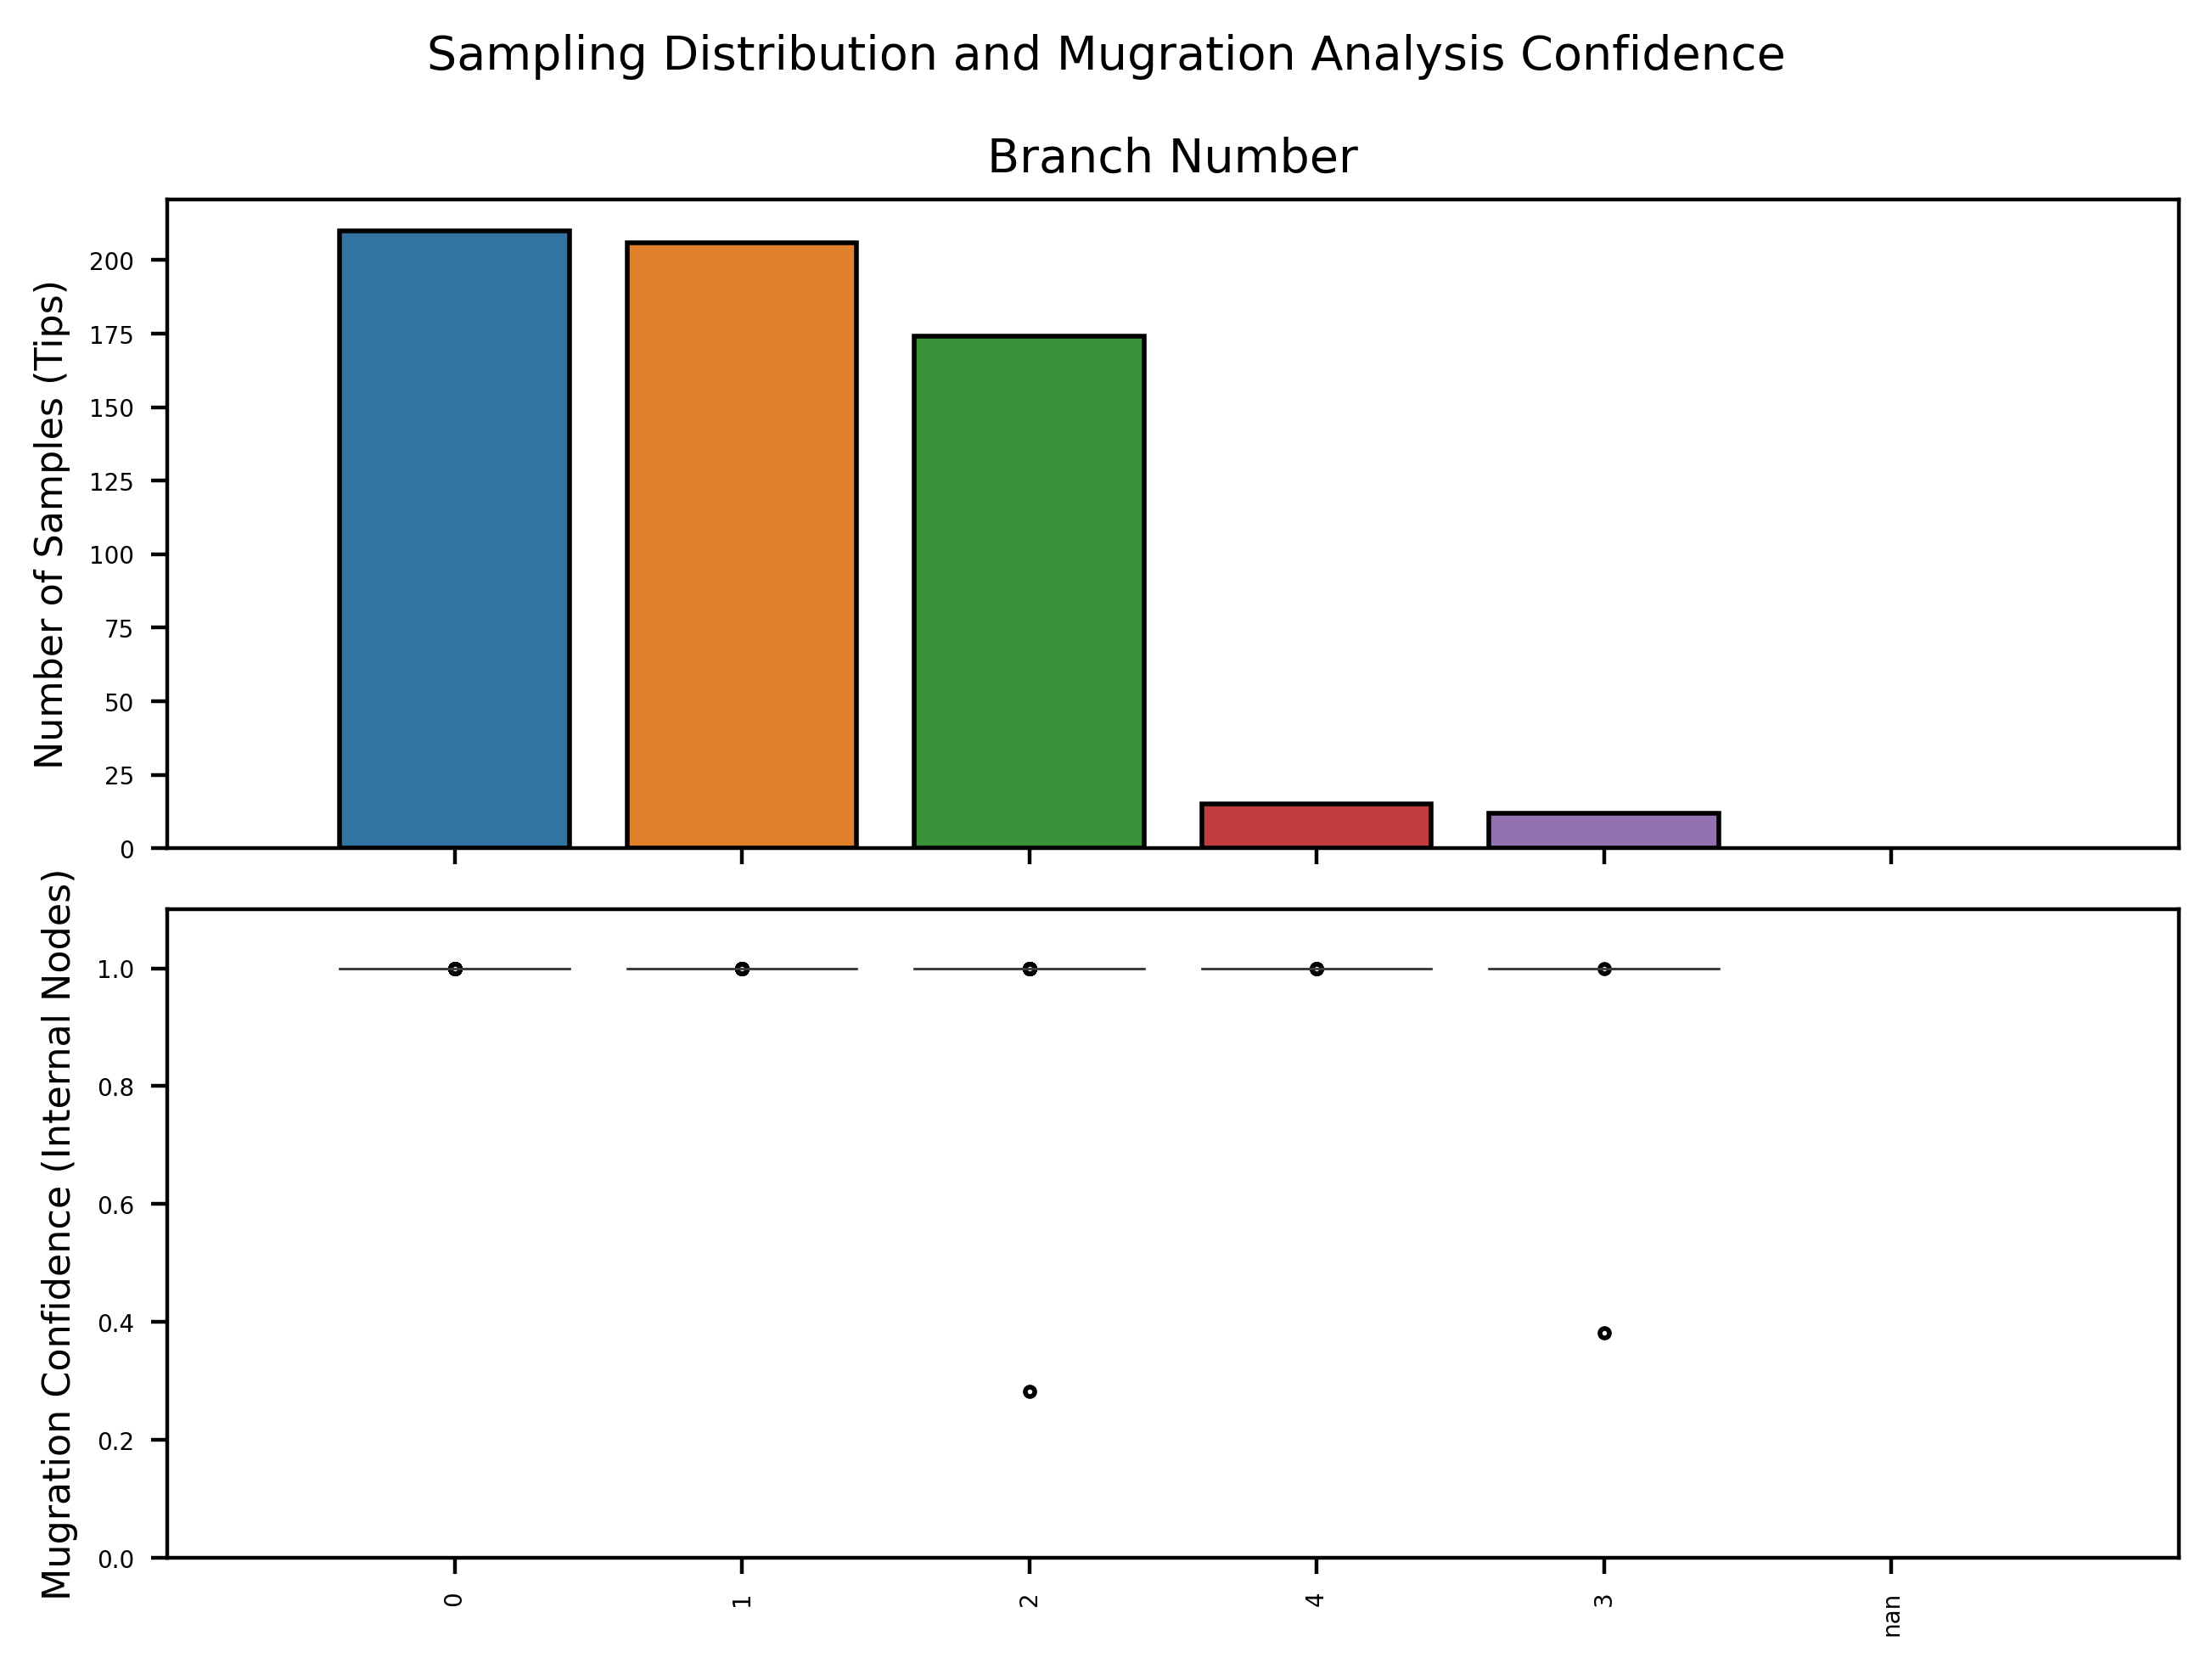

In [10]:
for attr in ATTRIBUTE_LIST:
    fig, (ax1, ax2) = plt.subplots(2, 
                               sharex=False, 
                               gridspec_kw={'hspace': 0},
                               figsize=figsize, 
                               dpi=dpi,
                               constrained_layout=True,
                              )
    
    # --------------------------
    # Axis 1 - Number of tips per state
    # Exclude samples with no attribute recorded
    data = tree_df[tree_df[attr] != NO_DATA_CHAR]
    label_order = list(data[attr].value_counts().index)
    label_order = [lab for lab in label_order if lab != "nan"] + ["nan"]
    
    sns.countplot(data=data, 
                  x=attr, 
                  #color="blue", 
                  edgecolor="black",
                  ax=ax1, 
                  order=label_order
                 )
    plt.setp(ax1.get_xticklabels(), visible=False)
    xticklabels = [item.get_text() for item in ax1.get_xticklabels()]
    ax1.set_xticklabels(xticklabels, rotation = 90, ha="right")
    ax1.set_xlabel("")
    ax1.set_ylabel("Number of Samples (Tips)")
    ax1.set_xlim(-1,len(label_order)) 
    ax1.set_title(attr.replace("_"," "))
    
    # --------------------------
    # Axis 2 - Mugration Confidence
    # Exclude nodes that are terminals (ie. branch support is grey)
    data = tree_df[tree_df["Branch_Support_Color"] != "grey"]
    
    # Fix typing
    if attr == "Branch_Number":
        label_order = [str(math.ceil(lab)) for lab in label_order if lab != "nan"] + ["nan"]

    # Customize outlier style
    flierprops = dict(marker='o', markerfacecolor='white', markersize=2,
                      linestyle='none', markeredgecolor='black')
    # Create a boxplot
    sns.boxplot(data=data, 
                  x="Mugration_" + attr, 
                  y="Mugration_" + attr + "_Confidence",
                  #color="blue", 
                  ax=ax2, 
                  order=label_order,
                  flierprops=flierprops)
    #plt.setp(ax2.get_xticklabels(), visible=False)
    xticklabels = [item.get_text() for item in ax2.get_xticklabels()]
    ax2.set_xticklabels(xticklabels, rotation = 90, ha="center")
    #ax2.axhline(y=MUG_CONF_THRESH, color=THRESH_COL, linewidth=0.5, linestyle='--')
    ax2.set_xlabel("")
    ax2.set_ylabel("Mugration Confidence (Internal Nodes)")
    ax2.set_xlim(-1,len(label_order))
    ax2.set_ylim(0, 1.1)
    
    fig.suptitle("Sampling Distribution and Mugration Analysis Confidence")
    
    out_path = os.path.join(outdir, SCRIPT_NAME + "_boxplot_{}.{}".format(attr.lower(), FMT)) 
    plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

---
# 4. Plot colored trees

## Color branches on mug/div tree according to state

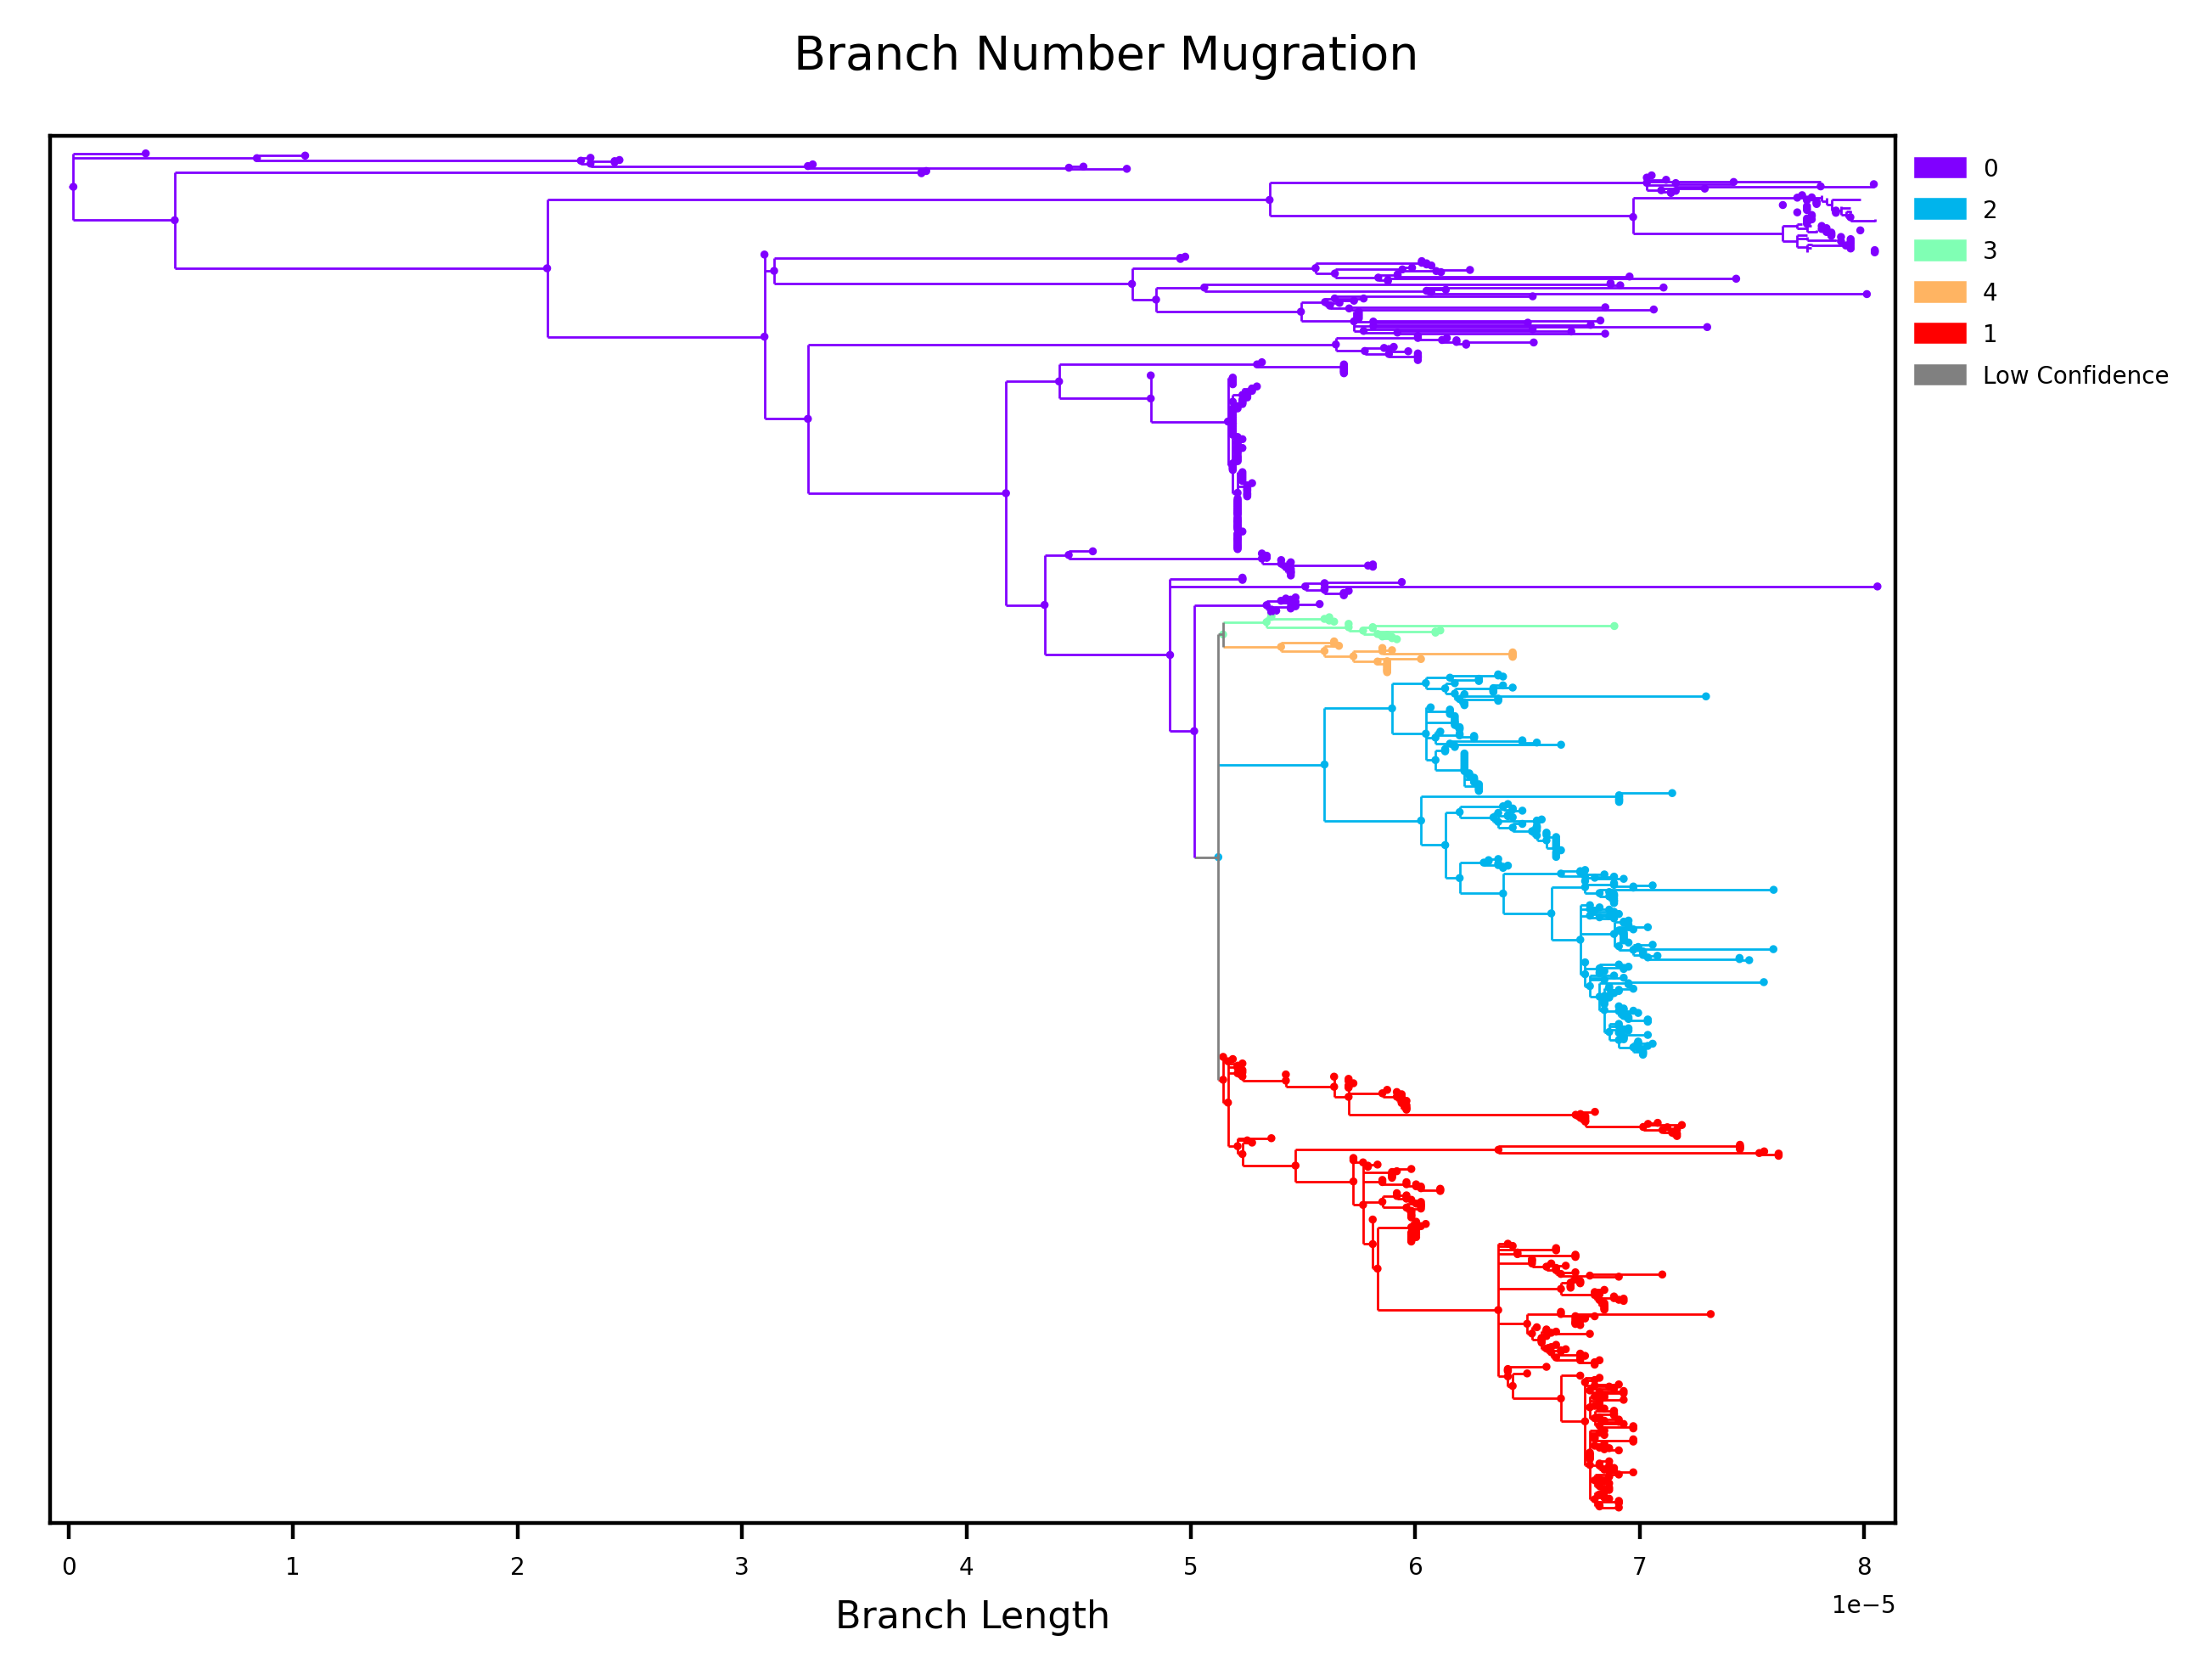

In [16]:
out_path_colors = os.path.join(outdir, SCRIPT_NAME + "_colors.tsv")
file_colors = open(out_path_colors, "w")

for attr in ATTRIBUTE_LIST:  
    if attr != "Branch_Major" and attr != "Branch_Number":
        continue
    
    # --------------------------------------------   
    # Canvas
    fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize, constrained_layout=True,)

    # --------------------------------------------
    # Color Tree
    hex_dict = color_tree(tree=tree_div, 
                          df=tree_df, 
                          attribute="Mugration_" + attr,
                          attribute_confidence="Mugration_" + attr + "_Confidence",
                          threshold_confidence=MUG_CONF_THRESH,                          
                          color_pal=CONT_COLOR_PAL)
    
    # Add the hex color dict to the dict
    mug_dict[attr]["hex_color"] = hex_dict  

    # Write to color file
    for state,color in hex_dict.items():
        file_colors.write(attr.lower() + "\t" + state + "\t" + color + "\n")    
        
    # Draw tree
    Phylo.draw(tree_div,
               axes=ax1, 
               show_confidence=False, 
               label_func = lambda x:'', 
               do_show=False)
    # --------------------------------------------
    # Draw tips
    colors = [mug_dict[attr]["hex_color"][state] for state in tree_df["Mugration_" + attr]]    
    ax1.scatter(data=tree_df, 
                x="coord_x", 
                y="coord_y", 
                s=0.5, 
                c=colors,
               )
    # --------------------------------------------
    # Ticks
    x_buffer = max(tree_df["coord_x"]) * 0.01
    y_buffer = math.ceil(len(tree_div.get_terminals()) * 0.01)   
    # --------------------------------------------
    # Limits
    ax1.set_xlim(0 - x_buffer, max(tree_df["coord_x"]) + x_buffer)    
    ax1.set_ylim(len(tree_div.get_terminals()) + y_buffer, 0 - y_buffer)
    ax1.set_yticks([])    
    # --------------------------------------------
    # Labels
    ax1.set_xlabel("Branch Length")
    ax1.set_ylabel("")
    fig.suptitle("{} Mugration".format(attr.replace("_"," ")))    
    # --------------------------------------------
    # Legend
    legend_elements = [patches.Patch(facecolor=value, edgecolor=value,) for value in mug_dict[attr]["hex_color"].values()]
    legend_labels = list(mug_dict[attr]["hex_color"].keys())
    ax1.legend(legend_elements, 
              legend_labels,
              bbox_to_anchor=(1.0, 1.0), 
              loc='upper left',
              frameon=False,
             )
    # --------------------------------------------
    # Export
    out_path = os.path.join(outdir, SCRIPT_NAME + "_tree_{}.{}".format(attr.lower(), FMT))  
    plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")
    
    # Save Tree!
    #out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_{}.phylo.obj".format(attr.lower()))
    #with open(out_path_dill_tree,"wb") as outfile:
    #    dill.dump(tree_div, outfile)
    
file_colors.close()

---
# 5. Export

## Dataframe

In [61]:
# Dataframe
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)

## Timetrees

In [63]:
# Phyloxml
tt_copy = copy.deepcopy(tt)
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + "_timetree.xml" )
Phylo.write(tt_copy.tree, out_path_xml, 'phyloxml')

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_timetree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_timetree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_timetree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

1

## Divtrees

In [64]:
tt_copy = copy.deepcopy(tt)
# Convert to divtree
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length

# Phyloxml
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + "_divtree.xml" )
Phylo.write(tt_copy.tree, out_path_xml, 'phyloxml')

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_divtree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_divtree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_divtree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

1

## Augur JSON

  - alignment (empty)
  - input_tree (tree_path)
  - nodes (node_dict)
  

In [52]:
import importlib
import sys
importlib.reload(sys.modules['config'])
from config import augur_export

In [53]:
augur_dict = augur_export(
    tree_path=tree_path, 
    aln_path=aln_path, 
    tree=tree_div, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord", "lat", "lon"],
    type_convert = {
        "Branch_Number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["NODE0"])

{'ufboot': 100.0, 'scf': 'NA', 'branch_length': 0.0, 'strain': 'NA', 'date': 'NA', 'datebp': 'NA', 'country': 'NA', 'province': 'NA', 'biovar': 'NA', 'branch_major': 'NA', 'branch_minor': 'NA', 'biosample': 'NA', 'biosamplecomment': 'NA', 'branch_number': '0', 'rate': 9.263553689093914e-09, 'rate_fold_change': 1.0, 'mutation_length': 2.148814885614286e-07, 'raw_date': '-4000-09-21', 'num_date': -3999.2774811378754, 'num_date_confidence': [-4114.0959399021, -3791.54718956593], 'num_date_bar': '6135.0959399021:5812.54718956593', 'clock_length': 0.1, 'reg_x': -3999.2774811378754, 'reg_y': 0.0, 'reg_bad': 'False', 'branch_number_confidence': {'0': 0.9999999960608318}, 'branch_number_entropy': 8.555654203704375e-08}


### Add Mugration Model to JSON

In [ ]:
# Dataframe
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)

# Phyloxml
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + ".xml" )
Phylo.write(tt.tree, out_path_xml, 'phyloxml')

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + ".nexus" )
Phylo.write(tt.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + ".treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt, outfile)
    
# Newick (remove comments)
tt_copy = copy.deepcopy(tt)
for c in tt_copy.tree.find_clades(): c.comment = None
    
# Newick Timetree
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Newick Divergence
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length
out_path_div_nwk = os.path.join(outdir, SCRIPT_NAME + "_divtree.nwk" )
Phylo.write(tt_copy.tree, out_path_div_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

In [55]:
out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

print(augur_dict["nodes"]["Reference"])

{'ufboot': 'NA', 'scf': 'NA', 'branch_length': 1.8768e-06, 'strain': 'NA', 'date': 1992.0, 'datebp': -29.0, 'country': 'United States of America', 'province': 'Colorado', 'biovar': 'Orientalis', 'branch_major': '1.ORI', 'branch_minor': '1.ORI1', 'biosample': 'NA', 'biosamplecomment': 'KEEP: Assembly Modern Reference', 'branch_number': '1', 'rate': 4.167237112130312e-08, 'rate_fold_change': 4.498529670137764, 'mutation_length': 1.720110095684973e-06, 'raw_date': '1991-12-22', 'num_date': 1991.9737186953694, 'num_date_confidence': [1992.0, 1992.0], 'num_date_bar': '29.0:29.0', 'clock_length': 26.09605904591581, 'reg_x': 1992.0, 'reg_y': 6.756317204086871e-05, 'reg_bad': 'False', 'branch_number_confidence': {'1': 1.0}, 'branch_number_entropy': -1.000088900581841e-12}


## Auspice JSON

Manual edits of https://github.com/nextstrain/augur/blob/master/augur/export_v2.py

This can then be used for auspice via:

```
HOST="localhost" auspice view --datasetDir .
```

In [57]:
auspice_dict = auspice_export(
    tree=tree_div, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlon_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_remote_json)
print("Validation successful for remote JSON.")

<class 'dict'>
Validating schema of '../../config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '../../results/mugration/mugration_auspice.json'...
Validating that the JSON is internally consistent...
Validation of '../../results/mugration/mugration_auspice.json' succeeded.
Validation successful for local JSON.
Validating produced JSON
Validating schema of '../../auspice/plague-phylogeography_mugration.json'...
Validating that the JSON is internally consistent...
Validation of '../../auspice/plague-phylogeography_mugration.json' succeeded.
Validation successful for remote JSON.
